# Neural Computation (Autumn 2019)
# Lab 6: Automatic Differentiation (Autograd)

Last week, we gave you a very brief introduction to Pytorch. This week, we will dive more deeply into the Deep Learning framework. By the end of this tutorial, you will know:

- How to create tensors in Pytorch via `torch.Tensor`
- How backpropgation is performed in Pytorch (with `autograd`)
- How to split the dataset into training and validation sets
- How to build a model using `nn.Module` and `nn.Linear` and train that model
- How to evaluate the trained model using the validation set

## Pytorch Tensors

The most basic building block of any Deep Learning library is tensors, which are matrix-like data structures very similar to Numpy's ndarrays with the advantage being that Tensors can also be stored/used on a GPUs to accelerate computing. A scalar has zero dimension, so is called 0D tensor. A vector (i.e., 1D tensor) has one dimension, while a matrix (2D tensor) has two dimension. Note that we introduced tensors in Lab 3 (Advanced Numpy, Tensors & Tensor Operations). If you do not remember what a tensor is, please revisiting Lab 3 again.

In this section, we will show you how to create a tensor using Pytorch. First, we need to `import` the package.

In [0]:
import torch
import numpy as np

You can construct a 3x4 randomly initialised matrix:

In [0]:
x = torch.rand(4,3)
print(x)

tensor([[0.1621, 0.7122, 0.6569],
        [0.7992, 0.3556, 0.5721],
        [0.7694, 0.9493, 0.3521],
        [0.7761, 0.3246, 0.7426]])


Construct a tensor directly from data:

In [0]:
x = torch.tensor([3, 4.5])
print(x)

tensor([3.0000, 4.5000])


You can retrieve the size of the tensor using `size` as follows:

In [0]:
print(x.size())

torch.Size([2])


There are many operations that can be performed on tensors. The addition operation can be done as follows:

In [0]:
x = torch.rand(3,4)
y = torch.rand(3,4)
print(x+y)

tensor([[1.1211, 0.7766, 1.4533, 0.7739],
        [0.5786, 0.6103, 0.9714, 1.3983],
        [0.7650, 0.5405, 0.5250, 1.3524]])


Or you can use another syntax:

In [0]:
print(torch.add(x, y))

tensor([[1.1211, 0.7766, 1.4533, 0.7739],
        [0.5786, 0.6103, 0.9714, 1.3983],
        [0.7650, 0.5405, 0.5250, 1.3524]])


You can also provide an output tensor as argument as follows:

In [0]:
result = torch.empty(3,4)
torch.add(x, y, out=result)
print(result)

tensor([[1.1211, 0.7766, 1.4533, 0.7739],
        [0.5786, 0.6103, 0.9714, 1.3983],
        [0.7650, 0.5405, 0.5250, 1.3524]])


You can also convert a Torch Tensor to a Numpy Array using `numpy()` function.

In [0]:
x = torch.ones(5)
print(x)
print(x.dtype)

y = x.numpy()
print(y)
print(y.dtype)

tensor([1., 1., 1., 1., 1.])
torch.float32
[1. 1. 1. 1. 1.]
float32


Convert Numpy Array to Torch Tensor. Notice how changing the np array has changed the Torch Tensor automatically.

In [0]:
x = np.ones(3)
y = torch.from_numpy(x)

np.add(x, 1, out=x)
print(x)
print(y)

[2. 2. 2.]
tensor([2., 2., 2.], dtype=torch.float64)


Tensors can be moved onto any device using the `.to` method. You can check whether a GPU is available using the `torch.cuda.is_available()` method. The `.to()` method sends your tensor to whatever device you specify, including your GPU (referred to as `cpu`) or your GPUs (referred to as `cuda` or `cuda:0`).

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # check whether a GPU is available
y = torch.ones(3,4, device=device)  # directly create a tensor on GPU
x = torch.rand(3,4).to(device)      # or just use .to(device) 
z = x+y
print(z)

tensor([[1.3904, 1.6009, 1.2566, 1.7936],
        [1.9408, 1.1332, 1.9346, 1.5936],
        [1.8694, 1.5677, 1.7411, 1.4294]])


As you have seen, `torch.Tensor` is the central class of the Pytorch package. If you now set its attribute `.require_grad` as `True`, it starts to track all operations on it. When you finish your computation you can call `.backward()` and have all the gradients computed automatically. The gradient for this tensor will be accumulated into `.grad` attribute.

The following piece of codes creates a tensor and set `requires_grad=True` to track computation with it.

In [0]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Perform a tensor operation:

In [0]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


A `Function` is also an important class for autograd implementation in Pytorch. ``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
`grad_fn is None`). In the example above, you see that `y` has a `grad_fn` since it was created as a result of an operation. We can print the value of that attribute:

In [0]:
print(y.grad_fn)

You can do more operations on `y`:

In [0]:
z = y * y * 2
out = z.mean()

print(z)
print(out)

tensor([[18., 18.],
        [18., 18.]], grad_fn=<MulBackward0>)
tensor(18., grad_fn=<MeanBackward0>)


You can change an existing Tensor's `requires_grad` flag in-place by using `.requires_grad_(...)`. The input flag defaults to `False` if not given. Note that anu operation that mutates a tensor in-place is post-fixed with an `_`. For example, `x.copy_(y)` and `x.t_()` will change `x`.

In [0]:
x = torch.randn(2, 2)
print(x.requires_grad)  # default to False

False


In [0]:
x.requires_grad_(True)   # change the flag to True
print(x.requires_grad)

True


In [0]:
y = (x + 1).sum()
print(y.requires_grad)
print(y.grad_fn)

True


## Gradients

Let's backprop now. Consider the fowllowing piece of codes:

In [0]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = y * y * 3
out= z.mean()

In [0]:
print("1: ", x)
print("2: ", y)
print("3: ", y.grad_fn)
print("4: ", z)
print("5: ", out)

1:  tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
2:  tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
3:  <AddBackward0 object at 0x7f0695c73160>
4:  tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)
5:  tensor(27., grad_fn=<MeanBackward0>)


If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.

In [0]:
out.backward()

Since `out` contains a single scalar (i.e., mean), `out.backward()` is equivalent to `out.backward(torch.tensor(1.))`.  You can retrieve the gradient of d(out)/dx as follows:

In [0]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


You should have got a matrix of ``4.5``. Let’s call the ``out``
*Tensor* “$o$”.
We have that $o = \frac{1}{4}\sum_i z_i$,
$z_i = 3(x_i+2)^2$ and $z_i\bigr\rvert_{x_i=1} = 27$.
Therefore,
$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i+2)$, hence
$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$.



Mathematically, if you have a vector valued function $\vec{y}=f(\vec{x})$,
then the gradient of $\vec{y}$ with respect to $\vec{x}$
is a Jacobian matrix:

\begin{align}J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\end{align}

Generally speaking, ``torch.autograd`` is an engine for computing
vector-Jacobian product. That is, given any vector
$v=\left(\begin{array}{cccc} v_{1} & v_{2} & \cdots & v_{m}\end{array}\right)^{T}$,
compute the product $v^{T}\cdot J$. If $v$ happens to be
the gradient of a scalar function $l=g\left(\vec{y}\right)$,
that is,
$v=\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$,
then by the chain rule, the vector-Jacobian product would be the
gradient of $l$ with respect to $\vec{x}$:

\begin{align}J^{T}\cdot v=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\left(\begin{array}{c}
   \frac{\partial l}{\partial y_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial y_{m}}
   \end{array}\right)=\left(\begin{array}{c}
   \frac{\partial l}{\partial x_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial x_{n}}
   \end{array}\right)\end{align}

(Note that $v^{T}\cdot J$ gives a row vector which can be
treated as a column vector by taking $J^{T}\cdot v$.)

This characteristic of vector-Jacobian product makes it very
convenient to feed external gradients into a model that has
non-scalar output.

## How to define a model in Pytorch?

### An example 

To illustrate this step, let's create some synthetic data. We choose a vector of some points for our feature `x` and create our labels (targets) using the following model $y=a + b \cdot x + \epsilon\cdot  \mathcal{N}$, where `a`, `b` and $\epsilon$ are some constants and $\mathcal{N}$ is noise following a standard normal distribution (mean=0, variance=1).

#### **Question 1**:
Let's consider `a=1`, `b=2` and $\epsilon=0.1$. Could you please generate a vector of 100 points for our feature `x` and another vector of the same size for our target `y`?

In [0]:
# Add you codes here (use x and y as variable names for input and tagets)
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + 0.1 * np.random.randn(100, 1)

Now we split the dataset into a trainning set (used for training, about 80% of the original dataset) and a validation set (used for testing, about 20%). We need to shuffle the array of indices:

In [3]:
indx = np.arange(100)  # indices for all data points in x
print("Before shuffle: \n", indx)

np.random.shuffle(indx)
print("After shuffle: \n", indx)

Before shuffle: 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
After shuffle: 
 [76 83 80 98  2 77 71 84 89 50 40 51 67 86 37 49  4 10 69 81  9 54 55 87
 64 44 90 75 33 30 93 95 14 61 11 13 15  7  0 19 35  6 12 65 70 88 56 58
 28 38 91 42  8 73 39 85 25 92 41 26  1 22 21 46 74 79 78 72 57 53 24 17
 66 32 31 62 59 52 82 23 36  5 45 99 43 16 48 94 34  3 18 47 60 68 63 27
 96 29 20 97]


Now split the indices into two sets:

In [0]:
train_indx = indx[:80]  # first 80% for training
val_indx = indx[80:]    # remaining 20% for validation

Split the dataset into training and validation sets:

In [5]:
# Generate inputs and targets for training step
x_train, y_train = x[train_indx], y[train_indx]
print(x_train.size, y_train.size)

# Generate inputs and targets for validation step
x_val, y_val = x[val_indx], y[val_indx]
print(x_val.size, y_val.size)

80 80
20 20


We need to convert these Numpy's ndarray into Torch tensors of type `float`:

In [0]:
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

x_val_tensor = torch.from_numpy(x_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

We can also plot the points using the `scatter` method.

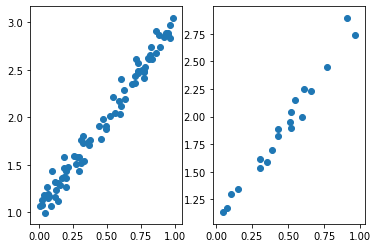

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows = 1, ncols = 2)
axs[0].scatter(x_train, y_train)  # plot the training dataset
axs[1].scatter(x_val, y_val)      # plot the validation dataset

### A simple linear gression model

Let's difine a simple linear regression model to learn the values for two parameters `a` and `b` in the model above.

As you might see last week, a model can be constructed in Pytorch using the `torch.nn` class. To explicitly define the model, you need to implement (at least) the following methods:

- `__init__(self)`, which defines the components that make up the model. Here, you are not limited to defining parameters and other models (or layers in neural networks) as our model's attributes (see more about this later).
- `forward(self, x)`, which performs the actual computation, that is, it ouputs a prediction, given the input `x`. You need not call the `forward(x)` method, and should call the whole model itself to perform a forward pass and output predictions.

Out first model will look like this:

In [0]:
import torch.nn as nn

class FirstModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.randn(1).float())
        self.b = nn.Parameter(torch.randn(1).float())
        
    def forward(self, x):
        return self.a + self.b * x

In the `__init__` method, we define two parameters, `a` and `b`, using the `Parameter()` class. By doing this, you can invoke the `parameters()` method of our model to retrieve an iterator over all model's parameters, that we can feed our optimiser. Moreover, we can get the current values for all parameters using the model's `state_dict()` method.

In the following, we will use stochastic gradient descent, i.e., the `SGD` method from `torch.optim` package, which takes two arguments: the list of model's parameters (`model.parameters()`) and the learning rate `lr`.

In [11]:
import torch.optim as optim
torch.manual_seed(42)

# Now we can create a model
model = FirstModel().to(device)

# we can also inspect its parameters
print("Before training: \n", model.state_dict())

Before training: 
 OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])


In [12]:
# set learning rate
lr = 1e-1

# set number of epoches, i.e., number of times we iterate through the training set
epoches = 100

# We use mean square error (MSELoss)
loss_fn = nn.MSELoss(reduction='mean')

# We also use stochastic gradient descent (SGD) to update a and b
optimiser = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epoches):
    model.train()             # set the model to training mode 
    optimiser.zero_grad()     # avoid accumulating gradients
    y_pred = model(x_train_tensor.to(device))
    loss = loss_fn(y_train_tensor.to(device), y_pred)
    loss.backward()           # calculate gradients
    optimiser.step()          # update model's params

print("After training: \n", model.state_dict())

After training: 
 OrderedDict([('a', tensor([1.1552])), ('b', tensor([1.7113]))])


When setting the number of epoches sufficiently large, you should be able to obtain some values for parameters `a` and `b` which are really close to their ground-truth values of 1 and 2. You can play with the model above by changing the number of epoches (`epoches`) and the learning rate (`lr`). 

### Nested model

In our model above, we manually created two parameters to perform a linear regression. We can also use Pytorch's `Linear` model as an attribute to our model, which results in a nested model. 

To do this, we need to change the `__int__` method, where we create an attribute that contains our nested `Linear` model. Also in the `forward()`, we will simply call the nested model itddelf to perform the forward pass.

Our new model will look like:


In [0]:
class NewModel(nn.Module):

    def __init__(self):
        super().__init__()
        # a simple linear layer with an input and an output
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

We can now call inspect the model's parameters by calling `parameters()`:

In [14]:
new_model = NewModel().to(device)
print(list(new_model.parameters()))

[Parameter containing:
tensor([[-0.2191]], requires_grad=True), Parameter containing:
tensor([0.2018], requires_grad=True)]


You should see that the model has two parameters. The first one is the **weight** `b`, while the other one is the **bias** `a` in our linear model defined at the beginning (recall that $y=a + bx + \epsilon \cdot \mathcal{N}$). You can see this clearly when using the `state_dict()` method.

In [15]:
print(new_model.state_dict())

OrderedDict([('linear.weight', tensor([[-0.2191]])), ('linear.bias', tensor([0.2018]))])


In [16]:
# print the model
print(new_model)  

NewModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


Because we use SGD as our optimiser, so we need mini-batches (i.e., small subsets of our dataset) to feed the model. In Pytorch, we can use the `DataLoader` class to do this. We simply need to tell it which dataset (of `TensorDataset`) to use, the size of the mini-batch (or simply batch size). The loader is an iterator-like, which can loop over the dataset and fetch a adifferent mini-batch every time.

In [0]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

Let's see how we train the model now.

In [18]:
# Now we can create a model
new_model = NewModel()

# we can also inspect its parameters
print("Before training: \n", new_model.state_dict())

# set learning rate
lr = 1e-1

# set number of epoches, i.e., number of times we iterate through the training set
epoches = 100

# We use mean square error (MSELoss)
loss_fn = nn.MSELoss(reduction='mean')

# We also use stochastic gradient descent (SGD) to update a and b
optimiser = optim.SGD(new_model.parameters(), lr=lr)

Before training: 
 OrderedDict([('linear.weight', tensor([[-0.4869]])), ('linear.bias', tensor([0.5873]))])


In [19]:
for epoch in range(epoches):
    new_model.train() 
    for x_batch, y_batch in train_loader:
        # send tensors to device (cpu/cuda)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimiser.zero_grad()
        y_pred = new_model(x_batch)
        loss = loss_fn(y_batch, y_pred)
        loss.backward()
        optimiser.step()

print("After training: \n", new_model.state_dict())

After training: 
 OrderedDict([('linear.weight', tensor([[1.9689]])), ('linear.bias', tensor([1.0247]))])


So far, we have defined an optimiser, a loss function and a (nested) model. We realise that if we use the codes above, we have to modify it whenever we'd like to use a different optimiser or a different loss function. You might think of making our codes more generic. How about writing a function that takes three arguments (optimiser, loss function and a model) and perform the training step. You will see below how to write a function in Python which returns another function.

In [0]:
def generic_code(model, loss_fn, optimiser):

    # define a function inside another function
    def train_step(x_batch, y_batch):
        optimiser.zero_grad()
        y_pred = model(x_batch)   # forward pass
        loss = loss_fn(y_batch, y_pred)  # calculate loss value
        loss.backward()                # autograd
        optimiser.step()               # update parameters  
        return loss.item()             # return the loss

    # return the newly defined function
    return train_step                # return a function

You can now perform the training process as usual:

In [21]:
new_model = NewModel()
print(new_model.state_dict())

# set learning rate
lr = 1e-1

# set number of epoches, i.e., number of times we iterate through the training set
epoches = 100

# We use mean square error (MSELoss)
loss_fn = nn.MSELoss(reduction='mean')

# We also use stochastic gradient descent (SGD) to update a and b
optimiser = optim.SGD(new_model.parameters(), lr=lr)
# after this step, train_step is actually a FUNCTION, which takes x_train_tensor 
# y_train_tensor as inputs and return the loss value
train_step = generic_code(new_model, loss_fn, optimiser)

# list to record the loss over training course
losses = list()

for epoch in range(epoches):
    for x_batch, y_batch in train_loader:
        losses.append(train_step(x_batch, y_batch))

print(new_model.state_dict())

OrderedDict([('linear.weight', tensor([[0.1125]])), ('linear.bias', tensor([-0.1656]))])
OrderedDict([('linear.weight', tensor([[1.9697]])), ('linear.bias', tensor([1.0258]))])


You can now plot the loss value over time as follows:

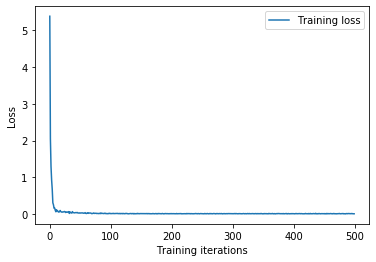

In [22]:
plt.plot(range(len(losses)), losses, label="Training loss")
plt.xlabel("Training iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluation

We have not used the validation set that we created at the beginning of the tutorial. We have split the dataset of 100 points into a training set (80%) and a validation set (20%). We now change our model to include the evaluation phase, that is, computing the validation loss. Intuitively speaking, since we do not use the validation set when training the model, so the validation set is actually *unseen* to our model, and turns out to be a good choice to inspect how well our model performs on unseen data (i.e., making predictions). 





We first need to create a DataLoader for the validation set.

In [0]:
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

Our training loop should look like this:

OrderedDict([('linear.weight', tensor([[0.8846]])), ('linear.bias', tensor([0.2476]))])
OrderedDict([('linear.weight', tensor([[1.8520]])), ('linear.bias', tensor([1.0865]))])


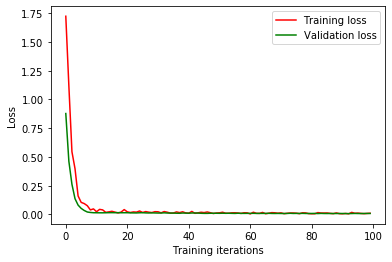

In [38]:
new_model = NewModel().to(device)
print(new_model.state_dict())

lr = 1e-1
epoches = 20
loss_fn = nn.MSELoss()
optimiser = optim.SGD(new_model.parameters(), lr=lr)

losses = list()
val_losses = list()
train_step = generic_code(new_model, loss_fn, optimiser)

for epoch in range(epoches):
    new_model.train()
    for x_batch, y_batch in train_loader:
        losses.append(train_step(x_batch, y_batch))
        
        with torch.no_grad():       # fix the model's params
            for x_val, y_val in val_loader:
                new_model.eval()    # set model to evaluation mode
                y_pred = new_model(x_val)
                val_loss = loss_fn(y_val, y_pred)
                val_losses.append(val_loss.item())

print(new_model.state_dict())
plt.plot(range(len(losses)), losses,'r', label="Training loss")
plt.plot(range(len(val_losses)), val_losses,'g', label="Validation loss")
plt.xlabel("Training iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Given the learning rate in `np.linspace(0.01, 0.5, 50)`. Could you plot a graph showing how the validation loss changes according to different values of the learning rate? Please use a number of epoches of at most, e.g., 200 for reasonable runtime.

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]


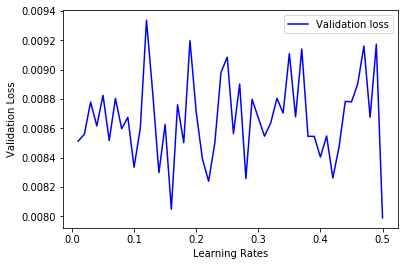

In [68]:
new_model = NewModel().to(device)

lrs = np.linspace(0.01, 0.5, 50)

epoches = 200
loss_fn = nn.MSELoss()
optimiser = optim.SGD(new_model.parameters(), lr=lr)

train_step = generic_code(new_model, loss_fn, optimiser)
losses = list()

for lr in lrs:
    val_losses = list()
    for epoch in range(epoches):
      new_model.train()
      for x_batch, y_batch in train_loader:
          train_step(x_batch, y_batch)
    with torch.no_grad():
      for x_val, y_val in val_loader:
        new_model.eval()
        y_pred = new_model(x_val)
        val_loss = loss_fn(y_val, y_pred)
        val_losses.append(val_loss.item())
        losses.append(np.mean(val_losses))
plt.plot(lrs, losses,'b', label="Validation loss")
plt.xlabel("Learning Rates")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()